In [1]:
%matplotlib inline
import numpy as np
from numpy.random import normal, randint
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad, simps
import sys, os, gc
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import tisesolve as ts
import time

# Inputs

In [2]:
# Number of potentials:
n_V = int(1e5)
# x limits:
x_i = -1
x_f = 1
# Number of x coordinates for spline:
n_x = 100
x_vec = np.linspace(x_i, x_f, n_x)
# Number of x coordinates for potential generation
n_xpot = 10
xpot_vec = np.linspace(x_i,x_f,n_xpot)
# Damping factor
lamb = 0.8
# Potential standard deviation
sigma = 30/(x_f-x_i)**2
# Number of basis wavefunctions
n_basis = 20
basis_vec = np.arange(1,n_basis+1)
# Number of eigenvalues to train the neural network to predict
n_eig = 10

print("Input parameters:\n"
      "  n_V= %i\n"
      "  x_i= %0.2f\n"
      "  x_f= %0.2f\n"
      "  n_x= %i\n"
      "  n_xpot= %i\n"
      "  lamb= %0.2f\n"
      "  sigma= %0.2f\n"
      "  n_basis= %i\n"
      "  n_eig= %i\n"
      % (n_V,x_i, x_f, n_x, n_xpot, lamb, sigma, n_basis, n_eig))

Input parameters:
  n_V= 100000
  x_i= -1.00
  x_f= 1.00
  n_x= 100
  n_xpot= 10
  lamb= 0.80
  sigma= 7.50
  n_basis= 20
  n_eig= 10



# Generate the potentials

In [3]:
# Randomly select the value of the potential at the selected points
V_xpot = normal(loc=0, scale=sigma, size=(n_V,n_xpot))

# Form a cubic spline for each potential
V_interp = interp1d(xpot_vec, V_xpot, kind="cubic", axis=1)

# Evaluate the cubic spline at the grid
V_grid = V_interp(x_vec)

# Calculate the average of each potential
V_avg = simps(x=x_vec, y=V_grid)/2

# Remove the average
#V_grid = V_grid - np.outer(V_avg, np.ones(n_x))

# Life is messy. Add some noise
V_grid = V_grid + np.random.normal(0,sigma/5, V_grid.shape)

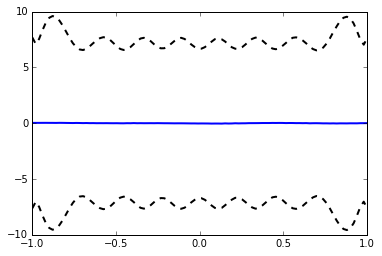

In [4]:
plt.clf()
plt.plot(x_vec, np.mean(V_grid, axis=0), 'b-', lw=2)
plt.plot(x_vec, np.mean(V_grid, axis=0)+np.std(V_grid, axis=0), 'k--', lw=2)
plt.plot(x_vec, np.mean(V_grid, axis=0)-np.std(V_grid, axis=0), 'k--', lw=2)

# Plot some random potentials

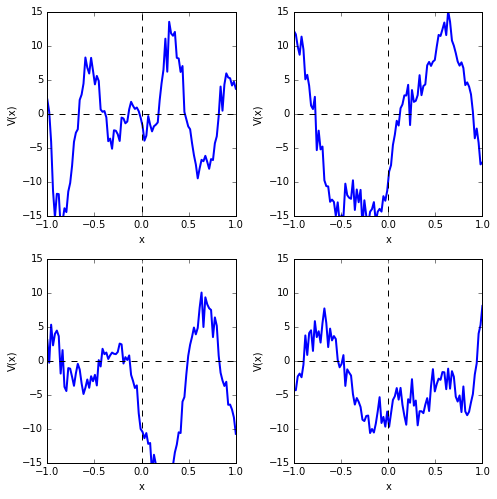

In [5]:
nrows = 2
ncols = 2
nplot = nrows * ncols
Vints = randint(0,n_V, nplot)
Vplot = V_grid[Vints,::]

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(7,7)
subax = axes.flat

for i in range(0,nplot):
        subax[i].plot(x_vec, Vplot[i], linewidth = 2)
        subax[i].axhline(y=0,xmin=-1,xmax=1, linestyle='dashed' ,color = 'k')
        subax[i].axvline(x=0,ymin=-10,ymax=10, linestyle='dashed' ,color = 'k')
        subax[i].set_xlabel("x")
        subax[i].set_ylabel("V(x)")
        subax[i].set_ylim((-2*sigma,2*sigma))

plt.tight_layout()
plt.show()
plt.close()

# Solve the eigensystem

In [6]:
t1=time.time()
eigvals, eigvecs = ts.eigsys(n_basis, x_vec, V_grid)
print("Eigenvalues shape:", eigvals.shape)
print(time.time()-t1)
print("Eigenvectors shape:", eigvecs.shape)

Calculating Hamiltonian matrices...
Status: 100.00 % completeEigenvalues shape: (100000, 20)
83.09197211265564
Eigenvectors shape: (100000, 20, 20)


# Visualize the solutions

In [7]:
# Calculate the probability distribution
prob = ts.prob_dist(eigvecs, x_vec)
print("Size of data: %0.5f MB" % (sys.getsizeof(prob)/1e6))

Size of data: 1600.00013 MB


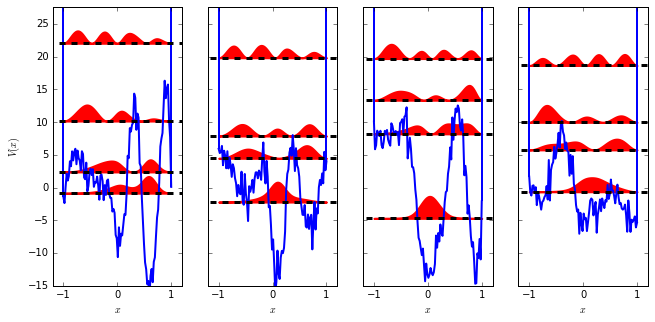

In [8]:
# Plot some random probability distributions
nrows = 1
ncols = 4
nplot = nrows * ncols
i_plt = randint(0,n_V, nplot)
numeigs = 4

V_grid_plt = V_grid[i_plt]
eigvals_plt = eigvals[i_plt]
prob_plt = prob[i_plt]

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharey='all', sharex='all')
fig.set_size_inches(8+8./3.,5)
subax = axes.flat

for i in range(nplot):
    subax[i].plot(x_vec, V_grid[i_plt[i]], linewidth = 2)
    for j in range(numeigs):
        subax[i].fill_between(x_vec, eigvals_plt[i,j], eigvals_plt[i,j]+1.5*prob_plt[i,j], lw=2, color='r')
        subax[i].get_xaxis().set_ticks([-1,0,1])
        subax[i].axhline(y=eigvals_plt[i,j], xmin = -1, xmax = 1, 
                         ls = 'dashed', color = 'k', lw =3)
        subax[i].vlines(x=-1, ymin = V_grid[i_plt[i],0], ymax = 3*ts.E0(numeigs), lw=2, color='b')
        subax[i].vlines(x=1, ymin = V_grid[i_plt[i],-1], ymax = 3*ts.E0(numeigs), lw=2, color='b')
    if i >= (nrows-1)*ncols:
        subax[i].set_xlabel("$x$")
    if i is 0 or i is ncols:
        subax[i].set_ylabel("$V(x)$")
    subax[i].set_ylim((-2*sigma,1.4*ts.E0(numeigs)))
    subax[i].set_xlim(1.2*x_i,1.2*x_f)

#plt.tight_layout()
plt.show()
plt.close()

# Scaled eigenvalues

In [9]:
eig_mu = np.mean(eigvals, axis = 0)
eig_std = np.std(eigvals, axis = 0)
eig_scaled = (eigvals - eig_mu) / eig_std

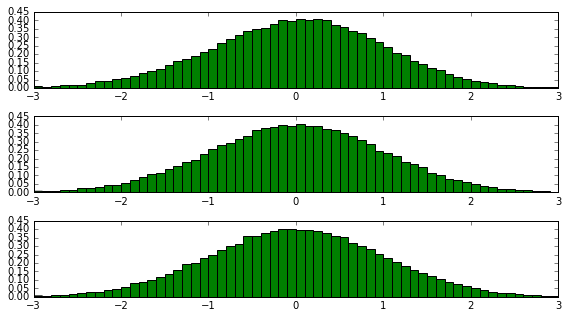

In [10]:
nrows = 3
ncols = 1
nplots = nrows*ncols
plt.clf()
fig, axes = plt.subplots(nrows, ncols)
fig.set_size_inches(8*ncols,1.5*nrows)
subax = axes.flat

nbins = 60
for i in range(0, nrows):
    subax[i].hist(eig_scaled[::,i], nbins, normed = 1, facecolor = 'green', 
                  alpha = 1, range = [-3,3])

plt.tight_layout()
plt.show()
plt.close()

# Neural Network

In [11]:
# Double the dataset using reflection symmetry
V_grid_flipped = V_grid[:,::-1]

# Quick and dirty test:
print(V_grid[2,0:3])
print(V_grid_flipped[2,-3:])

X = np.concatenate( (V_grid, V_grid_flipped) )
y = np.concatenate( (eig_scaled, eig_scaled) )[::,0:n_eig]

[-16.35765155 -17.35866106 -14.77685401]
[-14.77685401 -17.35866106 -16.35765155]


In [12]:
# Split test and train
test_frac = 0.3
random_state = 6
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=random_state
)
print("X shape, y shape: ", X.shape, y.shape)
print("X_train shape, y_train shape: ", X_train.shape, y_train.shape)
print("X_test shape, y_test shape: ", X_test.shape, y_test.shape)

X shape, y shape:  (200000, 100) (200000, 10)
X_train shape, y_train shape:  (140000, 100) (140000, 10)
X_test shape, y_test shape:  (60000, 100) (60000, 10)


In [13]:
hidden_layers = (100,100)
model =MLPRegressor(hidden_layer_sizes=hidden_layers,
                    activation = 'tanh',
                    algorithm = 'adam',
                    alpha = 0.001,
                    beta_1 = 0.85,
                    beta_2 = 0.9,
                    batch_size = 'auto',
                    max_iter = 2000,
                    tol = 1e-8,
                    learning_rate_init = 0.0001,
                    verbose = True
                 )

In [14]:
# Train the network
model.fit(X_train,y_train)

Iteration 1, loss = 0.15383097
Iteration 2, loss = 0.07046625
Iteration 3, loss = 0.06105464
Iteration 4, loss = 0.05485586
Iteration 5, loss = 0.04872840
Iteration 6, loss = 0.04314035
Iteration 7, loss = 0.03903253
Iteration 8, loss = 0.03600662
Iteration 9, loss = 0.03355657
Iteration 10, loss = 0.03153875
Iteration 11, loss = 0.02983044
Iteration 12, loss = 0.02832851
Iteration 13, loss = 0.02702511
Iteration 14, loss = 0.02584218
Iteration 15, loss = 0.02475498
Iteration 16, loss = 0.02375063
Iteration 17, loss = 0.02283114
Iteration 18, loss = 0.02193846
Iteration 19, loss = 0.02108557
Iteration 20, loss = 0.02029290
Iteration 21, loss = 0.01953677
Iteration 22, loss = 0.01884051
Iteration 23, loss = 0.01817442
Iteration 24, loss = 0.01755844
Iteration 25, loss = 0.01698093
Iteration 26, loss = 0.01642724
Iteration 27, loss = 0.01588792
Iteration 28, loss = 0.01538963
Iteration 29, loss = 0.01491828
Iteration 30, loss = 0.01446558
Iteration 31, loss = 0.01404083
Iteration 32, los

MLPRegressor(activation='tanh', algorithm='adam', alpha=0.001,
       batch_size='auto', beta_1=0.85, beta_2=0.9, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100, 100),
       learning_rate='constant', learning_rate_init=0.0001, max_iter=2000,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, tol=1e-08, validation_fraction=0.1,
       verbose=True, warm_start=False)

# Testing the NN

### Calculate errors on the training set as a reference point

In [15]:
# eigenvalue prediction
y_pred_train = model.predict(X_train)
err_train = np.sqrt(np.mean((y_pred_train - y_train)**2, axis=0))
print("Prediction error for each eigenvalue in the training set as ratio of std. dev.: \n", err_train)
print("Uniform average of prediction errors:\n %0.3f" % np.mean(err_train))

# Relative error
eig_pred_train = y_pred_train*eig_std[0:n_eig]+eig_mu[0:n_eig]
eig_train = y_train*eig_std[0:n_eig]+eig_mu[0:n_eig]
rel_err_train = np.mean(np.abs((eig_pred_train - eig_train)/eig_train), axis=0)
print("Prediction error for each eigenvalue in the training set as ratio of true value (rel. err.):\n", rel_err_train)

Prediction error for each eigenvalue in the training set as ratio of std. dev.: 
 [ 0.02581857  0.02675187  0.02629889  0.02305643  0.02021618  0.01621437
  0.01421465  0.01281611  0.01117344  0.01107328]
Uniform average of prediction errors:
 0.019
Prediction error for each eigenvalue in the training set as ratio of true value (rel. err.):
 [ 0.13284192  0.07365168  0.00720109  0.00235972  0.00117734  0.00065142
  0.00044131  0.00030682  0.00021709  0.00017299]


### Calculate errors on the test set

In [16]:
# eigenvalue prediction
y_pred_test = model.predict(X_test)
err_test = np.sqrt(np.mean((y_pred_test - y_test)**2, axis=0))
print("Prediction error for each eigenvalue in the testing set as ratio of std. dev.: \n", err_test)
print("Uniform average of prediction errors:\n %0.3f" % np.mean(err_test))

# Relative error
eig_pred_test = y_pred_test*eig_std[0:n_eig]+eig_mu[0:n_eig]
eig_test = y_test*eig_std[0:n_eig]+eig_mu[0:n_eig]
rel_err_test = np.mean(np.abs((eig_pred_test - eig_test)/eig_test), axis=0)
print("Prediction error for each eigenvalue in the testing set as ratio of true value (rel. err.):\n", rel_err_test)

Prediction error for each eigenvalue in the testing set as ratio of std. dev.: 
 [ 0.02710743  0.0280182   0.02788999  0.02386713  0.02099968  0.01669709
  0.01453709  0.01334371  0.01164625  0.01159899]
Uniform average of prediction errors:
 0.020
Prediction error for each eigenvalue in the testing set as ratio of true value (rel. err.):
 [ 0.16908822  0.07065185  0.00561865  0.00240527  0.00120156  0.0006603
  0.00044554  0.0003106   0.00021986  0.00017547]


## Visualize the predictions

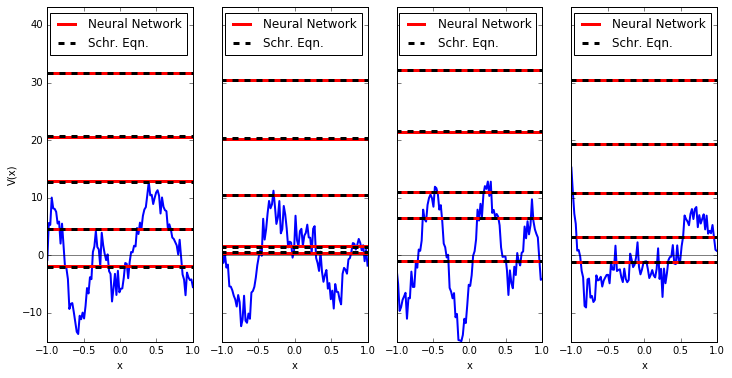

In [17]:
nrows = 1
ncols = 4
nplot = nrows * ncols
indplt = randint(0,X_test.shape[0], nplot)
numeigsplt = 5

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharey=True)
fig.set_size_inches(12,6)
subax = axes.flat

for i in range(0, len(indplt)):
        subax[i].plot(x_vec, X_test[indplt[i]], linewidth = 2, label='$V(x)$')
        subax[i].axhline(y=0,xmin=-1,xmax=1, linestyle='solid' ,color = 'k', lw=0.5)
        for j in range(0, numeigsplt):
            lastaxNN = subax[i].axhline(y=eig_pred_test[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'solid', color = 'r', lw = 3, label = 'Neural Network')
            lastaxSE = subax[i].axhline(y=eig_test[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'dashed', color = 'k', lw =3, label = 'Schr. Eqn.')

        subax[i].set_xlabel("x")
        if i==0:
            subax[i].set_ylabel("V(x)")
        subax[i].set_ylim((-2*sigma, 1.4*ts.E0(numeigsplt)))
        subax[i].legend([lastaxNN, lastaxSE], ["Neural Network", "Schr. Eqn."], fontsize=12)

# plt.tight_layout();
plt.show();
plt.draw()

## Test Cases

### Square well

In [18]:
V_square = np.asarray([np.zeros(n_x)])

# eigenvalue prediction
y_square_pred = model.predict(V_square)[0]
y_square_test = (ts.E0(np.arange(1,n_eig+1)) - eig_mu[0:n_eig])/eig_std[0:n_eig]
err_square = np.sqrt((y_square_pred - y_square_test)**2)
print("Prediction error for each eigenvalue as ratio of std. dev.: \n", err_square)
print("Uniform average of prediction errors:\n %0.3f" % np.mean(err_square))

# Relative error
eig_square_pred = y_square_pred*eig_std[0:n_eig]+eig_mu[0:n_eig]
eig_square_test = y_square_test*eig_std[0:n_eig]+eig_mu[0:n_eig]
rel_err = np.abs((eig_square_pred - eig_square_test)/eig_square_test)
print("Prediction error for each eigenvalue as ratio of true value (rel. err.):\n", rel_err)

Prediction error for each eigenvalue as ratio of std. dev.: 
 [ 0.0113005   0.00605058  0.00064374  0.00180043  0.00225165  0.00795942
  0.00250519  0.00238019  0.00723549  0.00642197]
Uniform average of prediction errors:
 0.005
Prediction error for each eigenvalue as ratio of true value (rel. err.):
 [  3.04790469e-02   3.75205830e-03   1.73917457e-04   2.67389903e-04
   2.00951431e-04   4.73845650e-04   1.08959889e-04   7.87578490e-05
   1.87914374e-04   1.34473561e-04]


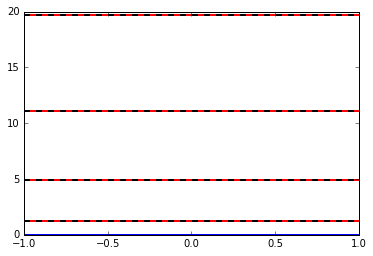

In [19]:
plt.clf()
plt.plot(x_vec, V_square[0], 'b-', lw=2)
for i in range(numeigs):
    plt.axhline(eig_square_pred[i], lw=2, ls='solid', color='r')
    plt.axhline(eig_square_test[i], lw=2, ls='dashed', color='k')

### Harmonic oscillator

In [20]:
# The harmonic oscillator potential with zero average value
def V_ho(A,x):
    return A*(x**2-1./3.)

# The energy levels
def E_ho(A,n):
    return -A/3. + (1 + 2*n)*np.sqrt(A/2)

In [21]:
A = 5*sigma
V_hos = [np.asarray(V_ho(A, x_vec))]
y_ho_pred = model.predict(V_hos)[0]
eig_ho_pred = y_ho_pred*eig_std[0:n_eig]+eig_mu[0:n_eig]
eig_ho_test, _ = ts.eigsys(n_basis, x_vec, np.asarray(V_hos))

Calculating Hamiltonian matrices...
Status: 100.00 % complete

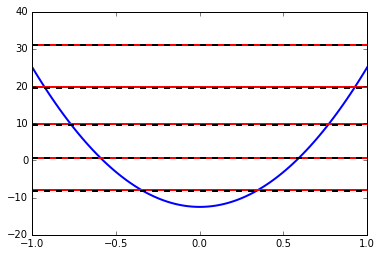

In [22]:
plt.clf()
plt.plot(x_vec, V_hos[0], 'b-', lw=2)
for i in range(5):
    plt.axhline(eig_ho_pred[i], lw=2, ls='solid', color='r')
    plt.axhline(eig_ho_test[0,i], lw=2, ls='dashed', color='k')

### Linear potential and symmetry test

In [23]:
# The harmonic oscillator potential with zero average value
A = 20
V_lin_p = [np.linspace(-A,A,n_x)]
V_lin_m = [np.linspace(A,-A,n_x)]

In [24]:
y_lin_p_pred = model.predict(V_lin_p)[0]
eig_lin_p_pred = y_lin_p_pred*eig_std[0:n_eig]+eig_mu[0:n_eig]
eig_lin_test, _ = ts.eigsys(n_basis, x_vec, np.asarray(V_lin_p))

y_lin_m_pred = model.predict(V_lin_m)[0]
eig_lin_m_pred = y_lin_m_pred*eig_std[0:n_eig]+eig_mu[0:n_eig]

Calculating Hamiltonian matrices...
Status: 100.00 % complete

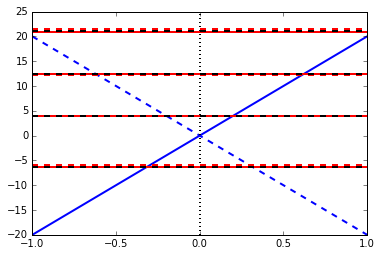

In [25]:
plt.clf()
plt.plot(x_vec, V_lin_p[0], 'b-', lw=2)
plt.plot(x_vec, V_lin_m[0], 'b--', lw=2)
plt.axvline(ls=':',lw=2,color='k')
for i in range(numeigs):
    plt.axhline(eig_lin_p_pred[i], lw=2, ls='solid', color='r')
    plt.axhline(eig_lin_m_pred[i], lw=2, ls='dashed', color='r')
    plt.axhline(eig_lin_test[0,i], lw=2, ls='dashed', color='k')

### Shifted square well

In [26]:
shift = 5
V_square = shift + np.asarray([np.zeros(n_x)])


# eigenvalue prediction
y_square_pred = model.predict(V_square)[0]
y_square_test = (shift+ts.E0(np.arange(1,n_eig+1)) - eig_mu[0:n_eig])/eig_std[0:n_eig]
err_square = np.sqrt((y_square_pred - y_square_test)**2)
print("Prediction error for each eigenvalue as ratio of std. dev.: \n", err_square)
print("Uniform average of prediction errors:\n %0.3f" % np.mean(err_square))

# Relative error
eig_square_pred = y_square_pred*eig_std[0:n_eig]+eig_mu[0:n_eig]
eig_square_test = y_square_test*eig_std[0:n_eig]+eig_mu[0:n_eig]
rel_err = np.abs((eig_square_pred - eig_square_test)/eig_square_test)
print("Prediction error for each eigenvalue as ratio of true value (rel. err.):\n", rel_err)

Prediction error for each eigenvalue as ratio of std. dev.: 
 [ 0.0132667   0.00720606  0.00146452  0.01782829  0.0035235   0.00026059
  0.00617638  0.00746318  0.01255998  0.00623674]
Uniform average of prediction errors:
 0.008
Prediction error for each eigenvalue as ratio of true value (rel. err.):
 [  7.08158155e-03   2.21963195e-03   2.72812971e-04   2.11262152e-03
   2.70592758e-04   1.39436243e-05   2.48111216e-04   2.32240970e-04
   3.10654331e-04   1.25508383e-04]


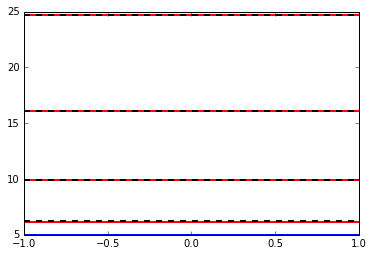

In [27]:
plt.clf()
plt.plot(x_vec, V_square[0], 'b-', lw=2)
for i in range(numeigs):
    plt.axhline(eig_square_pred[i], lw=2, ls='solid', color='r')
    plt.axhline(eig_square_test[i], lw=2, ls='dashed', color='k')

### Noisy ho

Calculating Hamiltonian matrices...
Status: 100.00 % complete

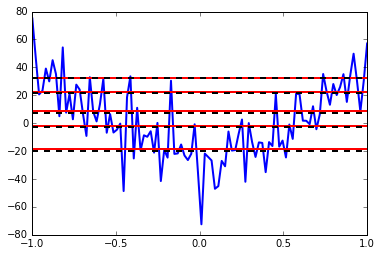

In [34]:
A = 10*sigma
V_hos = [np.asarray(V_ho(A, x_vec))+np.random.normal(0,2*sigma, n_x)]
y_ho_pred = model.predict(V_hos)[0]
eig_ho_pred = y_ho_pred*eig_std[0:n_eig]+eig_mu[0:n_eig]
eig_ho_test, _ = ts.eigsys(n_basis, x_vec, np.asarray(V_hos))

plt.clf()
plt.plot(x_vec, V_hos[0], 'b-', lw=2)
for i in range(5):
    plt.axhline(eig_ho_pred[i], lw=2, ls='solid', color='r')
    plt.axhline(eig_ho_test[0,i], lw=2, ls='dashed', color='k')